In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.options.display.max_columns = None

## Load Data

In [34]:
df = pd.read_csv('data/analytic_data2019.csv', low_memory=False)
df.head()
print(df.shape)

(3195, 534)


In [35]:
# Remove extraneous columns used for calculating features
headers_ = [x for x in df.columns if 'raw value' in x 
            or 'FIPS' in x 
            or 'State Abbreviation' in x 
            or 'Name' in x 
            or 'Release Year' in x
            or 'County Ranked' in x
            or 'Percentage of households' in x
            ]
df = df[headers_]

# Remove National and State level aggregators, and unnecessary secondary column header row
df = df[df['County FIPS Code'] != '000']
df.drop([0], inplace=True)
df.reset_index(drop=True)

# Fill columns with vals missing in unique cases (health care providers, missing = 0)
df.fillna({'Mental health providers raw value':0, 'Dentists raw value':0, 
           'Primary care physicians raw value':0}, inplace=True)

# Fill missing water violations elements with 0,1 in proportion to dataset at large (~2|3)
for ind, val in df.loc[df['Drinking water violations raw value'].isna(), ['Drinking water violations raw value']].iterrows():
    if ind%3 == 0:
        df['Drinking water violations raw value'][ind] = 1
    else:
        df['Drinking water violations raw value'][ind] = 0
        
# Grab other column names where more than 10% of data is misisng and drop from dataset
drop_for_msng_vals = [index for index, value in df.isna().mean().iteritems() if value>.1]
df.drop(drop_for_msng_vals, axis=1, inplace=True)

# number of columns is reduced from 534 to 72
df.shape

(3142, 72)

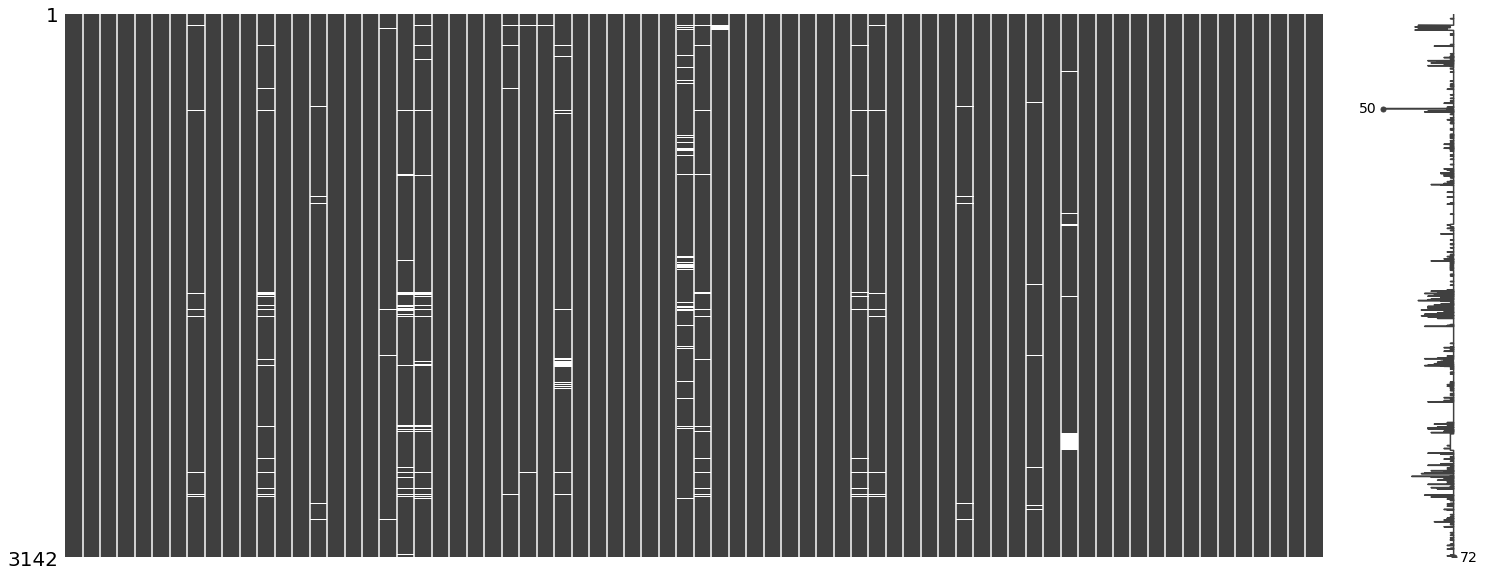

In [36]:
msno.matrix(df)

In [46]:
# Grab names for numeric data columns and convert those columns to numeric datatype
headers2_ = [x for x in df.columns if 'raw value' in x or 'Percentage of households' in x]
df[headers2_] = df[headers2_].apply(pd.to_numeric)
# type(df['High school graduation raw value'][5])  # this line confirms relevant fields converted to numeric dtype 

# bin counties by grad rate quantiles
quantiles = df['High school graduation raw value'].quantile(np.linspace(.25,.75,3)).round(2)
df['hs_grad_bins']=pd.qcut(df['High school graduation raw value'], 4, labels=['0-'+str(quantiles[.25]), 
                                                                              str(quantiles[.25])+'-'+str(quantiles[.5]),
                                                                              str(quantiles[.5])+'-'+str(quantiles[.75]),
                                                                              str(quantiles[.75])+'-100'])
df['hs_grad_bins'].value_counts()

0.9-0.94    762
0.85-0.9    761
0-0.85      761
0.94-100    759
Name: hs_grad_bins, dtype: int64

### Check for colinearity

In [47]:
def gen_high_corrs(corr_matrix):
    temps = {'rs':[], 'cs':[], 'vs':[]}
    for col in corr_matrix.columns:
        for row, value in corr_matrix[col].iteritems():
            if value > .5 or value <-.5:
                temps['rs'].append(row)
                temps['cs'].append(col)
                temps['vs'].append(value)
                temps_df = pd.DataFrame(temps)
    return temps_df #, temps_df.shape

def corr_check(header_index_list, df):
    mini_corr_matrix = df.drop(header_index_list, axis=1).corr()
    sns.heatmap(mini_corr_matrix)
    return mini_corr_matrix#gen_high_corrs(mini_corr_matrix).cs.value_counts()



### Identify variables with high correlations to eachother

In [44]:
corr_matrix = df.corr()
corr_matrix.reindex(corr_matrix['High school graduation raw value']
                    .abs().sort_values(ascending=False)
                    .index)['High school graduation raw value']

High school graduation raw value                                        1.000000
Severe housing problems raw value                                      -0.388523
Sexually transmitted infections raw value                              -0.367216
% Non-Hispanic white raw value                                          0.363300
Children in single-parent households raw value                         -0.353172
Percentage of households with high housing costs                       -0.308747
Violent crime raw value                                                -0.302623
Severe housing cost burden raw value                                   -0.301027
Children eligible for free or reduced price lunch raw value            -0.292416
Mental health providers raw value                                      -0.287194
% American Indian and Alaskan Native raw value                         -0.282311
Homeownership raw value                                                 0.275295
Percentage of households wit

['Poor or fair health raw value', 'Children in poverty raw value', 'Frequent physical distress raw value', 'Food insecurity raw value', 'Premature age-adjusted mortality raw value', 'Frequent mental distress raw value', 'Poor physical health days raw value', 'Children eligible for free or reduced price lunch raw value', 'Adult smoking raw value', 'Median household income raw value', 'Excessive drinking raw value', 'Physical inactivity raw value', 'Poor mental health days raw value', 'Some college raw value', 'Insufficient sleep raw value', 'Food environment index raw value', '% Non-Hispanic white raw value', 'Severe housing problems raw value', 'Injury deaths raw value', 'Preventable hospital stays raw value', 'Driving alone to work raw value', 'Mammography screening raw value', 'Flu vaccinations raw value', 'Injury deaths raw value', 'Social associations raw value', 'Limited access to healthy foods raw value', 'Long commute - driving alone raw value', 'Food environment index raw value

,Premature death raw value,Low birthweight raw value,Adult obesity raw value,Alcohol-impaired driving deaths raw value,Sexually transmitted infections raw value,Teen births raw value,Uninsured raw value,Primary care physicians raw value,Dentists raw value,Mental health providers raw value,High school graduation raw value,Unemployment raw value,Income inequality raw value,Children in single-parent households raw value,Violent crime raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,Percentage of households with high housing costs,Percentage of households with overcrowding,Percentage of households with lack of kitchen or plumbing facilities,Diabetes prevalence raw value,Other primary care providers raw value,Homeownership raw value,Population raw value,% 65 and older raw value,% Non-Hispanic African American raw value,% American Indian and Alaskan Native raw value,% Asian raw value,% Native Hawaiian/Other Pacific Islander raw value,% Hispanic raw value,% not proficient in English raw value,% Females raw value,% Rural raw value
Premature death raw value,1.000000,0.533158,0.468707,0.005830,0.361892,0.676342,0.303380,-0.267241,-0.240317,-0.074564,-0.132765,0.450145,0.412613,0.537114,0.251130,0.155092,-0.016595,-0.003225,0.166129,0.165107,0.631990,0.068672,-0.052501,-0.182187,0.100371,0.332571,0.320282,-0.305127,-0.075881,-0.134674,-0.209726,0.112027,0.276362
Low birthweight raw value,0.533158,1.000000,0.276007,-0.052540,0.436322,0.459334,0.231170,-0.144370,-0.159230,-0.033764,-0.161490,0.320608,0.475352,0.582360,0.383562,0.202356,-0.041986,0.239707,0.006908,-0.060739,0.489759,0.006276,-0.188230,-0.012587,-0.055006,0.688299,-0.080445,-0.096953,-0.042337,-0.028422,-0.065461,0.112798,0.027052
Adult obesity raw value,0.468707,0.276007,1.000000,-0.003479,0.183052,0.397354,0.040757,-0.299670,-0.271520,-0.240177,0.029075,0.245203,0.118750,0.329844,0.106472,0.322031,-0.091962,-0.209447,-0.039820,-0.007326,0.668267,-0.041429,0.093901,-0.247067,-0.051740,0.328332,0.074488,-0.313439,-0.113982,-0.292162,-0.237675,0.068598,0.241509
Alcohol-impaired driving deaths raw value,0.005830,-0.052540,-0.003479,1.000000,-0.004670,-0.079092,-0.077490,-0.004090,0.042908,0.043043,-0.038536,0.050453,-0.027326,-0.014796,-0.029459,-0.131086,0.014531,-0.014425,0.038387,0.083376,-0.062655,-0.025087,0.034466,-0.017530,0.067223,-0.035742,0.136829,0.011446,0.037031,-0.080356,-0.072442,-0.043976,0.067695
Sexually transmitted infections raw value,0.361892,0.436322,0.183052,-0.004670,1.000000,0.341550,0.245725,0.065180,0.114022,0.214800,-0.367216,0.251499,0.431458,0.576807,0.519146,0.141526,0.010293,0.350689,0.376649,0.200707,0.159466,0.173707,-0.541813,0.140730,-0.364328,0.594618,0.356590,0.102319,0.034353,0.088225,0.093056,0.157717,-0.274470
Teen births raw value,0.676342,0.459334,0.397354,-0.079092,0.341550,1.000000,0.518066,-0.329189,-0.267922,-0.128401,-0.149762,0.408823,0.328414,0.478483,0.283081,0.091177,0.014981,-0.112113,0.363900,0.147324,0.472621,-0.006476,-0.135947,-0.155430,-0.074629,0.238793,0.255688,-0.260213,-0.016139,0.261967,0.182678,-0.093491,0.158571
Uninsured raw value,0.303380,0.231170,0.040757,-0.077490,0.245725,0.518066,1.000000,-0.234999,-0.243357,-0.167966,-0.085788,0.124876,0.197714,0.212667,0.128037,-0.118033,0.070407,-0.038705,0.409572,0.181931,0.162265,-0.091665,-0.107203,-0.069224,-0.035123,0.184362,0.254541,-0.099317,-0.001987,0.441331,0.397575,-0.101950,0.161273
Primary care physicians raw value,-0.267241,-0.144370,-0.299670,-0.004090,0.065180,-0.329189,-0.234999,1.000000,0.549926,0.442902,-0.075424,-0.151961,0.036019,-0.057635,0.098498,-0.071732,0.057020,0.244534,-0.052099,0.008277,-0.305941,0.482570,-0.286122,0.200965,-0.074668,-0.050925,-0.010265,0.300777,0.055253,-0.043019,0.013281,0.193793,-0.428193
Dentists raw value,-0.240317,-0.159230,-0.271520,0.042908,0.114022,-0.267922,-0.243357,0.549926,1.000000,0.444800,-0.149247,-0.099667,0.009685,-0.027743,0.110552,-0.060922,0.071844,0.262134,0.0127

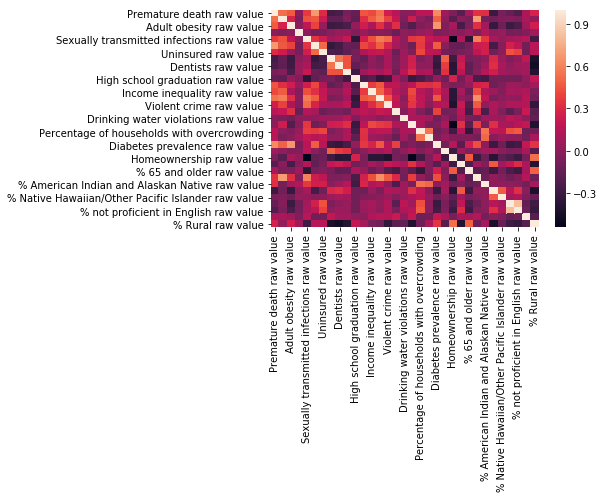

In [45]:
corr_matrix = df.corr()
drop_high_corrs_list = gen_high_corrs(corr_matrix).cs.value_counts().index[[0,1,2,3,4,5,7,9,10,12,14,16,17,18,19,20,22]]
temp_ls = list(drop_high_corrs_list)
temp_ls = temp_ls + ['Severe housing problems raw value',
               'Injury deaths raw value', 
               'Preventable hospital stays raw value', 
               'Driving alone to work raw value', 
               'Mammography screening raw value', 
               'Flu vaccinations raw value', 
               'Injury deaths raw value',
               'Social associations raw value', 
               'Limited access to healthy foods raw value',
               'Long commute - driving alone raw value', 
               'Food environment index raw value',
               'Access to exercise opportunities raw value',
               'Uninsured adults raw value', 
               'Uninsured children raw value',
               'Severe housing cost burden raw value',
               '% below 18 years of age raw value',
               'Life expectancy raw value']
print(temp_ls)
corr_check(temp_ls, df)

### Define and drop all columns that will be removed to reduce multicolinearity.

In [46]:
extraneous_features = ['Poor or fair health raw value', 
                       'Frequent physical distress raw value', 
                       'Premature age-adjusted mortality raw value', 
                       'Food insecurity raw value', 
                       'Children in poverty raw value', 
                       'Frequent mental distress raw value', 
                       'Premature death raw value', 
                       'Poor physical health days raw value', 
                       'Adult smoking raw value', 
                       'Poor mental health days raw value', 
                       'Excessive drinking raw value', 
                       'Diabetes prevalence raw value', 
                       'Some college raw value', 
                       'Physical inactivity raw value', 
                       'Insufficient sleep raw value', 
                       'Low birthweight raw value', 
                       '% Non-Hispanic white raw value', 
                       'Severe housing problems raw value', 
                       'Injury deaths raw value', 
                       'Preventable hospital stays raw value', 
                       'Driving alone to work raw value', 
                       'Mammography screening raw value', 
                       'Flu vaccinations raw value', 
                       'Injury deaths raw value', 
                       'Social associations raw value', 
                       'Limited access to healthy foods raw value', 
                       'Long commute - driving alone raw value', 
                       'Food environment index raw value', 
                       'Access to exercise opportunities raw value', 
                       'Uninsured adults raw value', 
                       'Uninsured children raw value', 
                       'Severe housing cost burden raw value', 
                       '% below 18 years of age raw value',
                       'High school graduation raw value',
                       'hs_grad_bins'
                       ]

features = df.drop(extraneous_features, axis=1)
headers3_ = [x for x in features.columns if 'raw value' in x or 'Percentage of households' in x]
features = df[headers3_]
features_and_target = df 
target = df['hs_grad_bins']

In [47]:
extas_remove_for_target_pickle= ['Poor or fair health raw value', 
                       'Frequent physical distress raw value', 
                       'Premature age-adjusted mortality raw value', 
                       'Food insecurity raw value', 
                       'Children in poverty raw value', 
                       'Frequent mental distress raw value', 
                       'Premature death raw value', 
                       'Poor physical health days raw value', 
                       'Adult smoking raw value', 
                       'Poor mental health days raw value', 
                       'Excessive drinking raw value', 
                       'Diabetes prevalence raw value', 
                       'Some college raw value', 
                       'Physical inactivity raw value', 
                       'Insufficient sleep raw value', 
                       'Low birthweight raw value', 
                       '% Non-Hispanic white raw value', 
                       'Severe housing problems raw value', 
                       'Injury deaths raw value', 
                       'Preventable hospital stays raw value', 
                       'Driving alone to work raw value', 
                       'Mammography screening raw value', 
                       'Flu vaccinations raw value', 
                       'Injury deaths raw value', 
                       'Social associations raw value', 
                       'Limited access to healthy foods raw value', 
                       'Long commute - driving alone raw value', 
                       'Food environment index raw value', 
                       'Access to exercise opportunities raw value', 
                       'Uninsured adults raw value', 
                       'Uninsured children raw value', 
                       'Severe housing cost burden raw value', 
                       '% below 18 years of age raw value',
                       ]

target_and_features_df = df.drop(extas_remove_for_target_pickle, axis=1)
for col in target_and_features_df[headers3_].columns:
    a = features[col].mean()
    target_and_features_df[col].fillna(a, inplace=True)

In [48]:
target_and_features_df.isna().any()

State FIPS Code                                                         False
County FIPS Code                                                        False
5-digit FIPS Code                                                       False
State Abbreviation                                                      False
Name                                                                    False
Release Year                                                            False
County Ranked (Yes=1/No=0)                                              False
Adult obesity raw value                                                 False
Alcohol-impaired driving deaths raw value                               False
Sexually transmitted infections raw value                               False
Teen births raw value                                                   False
Uninsured raw value                                                     False
Primary care physicians raw value                               

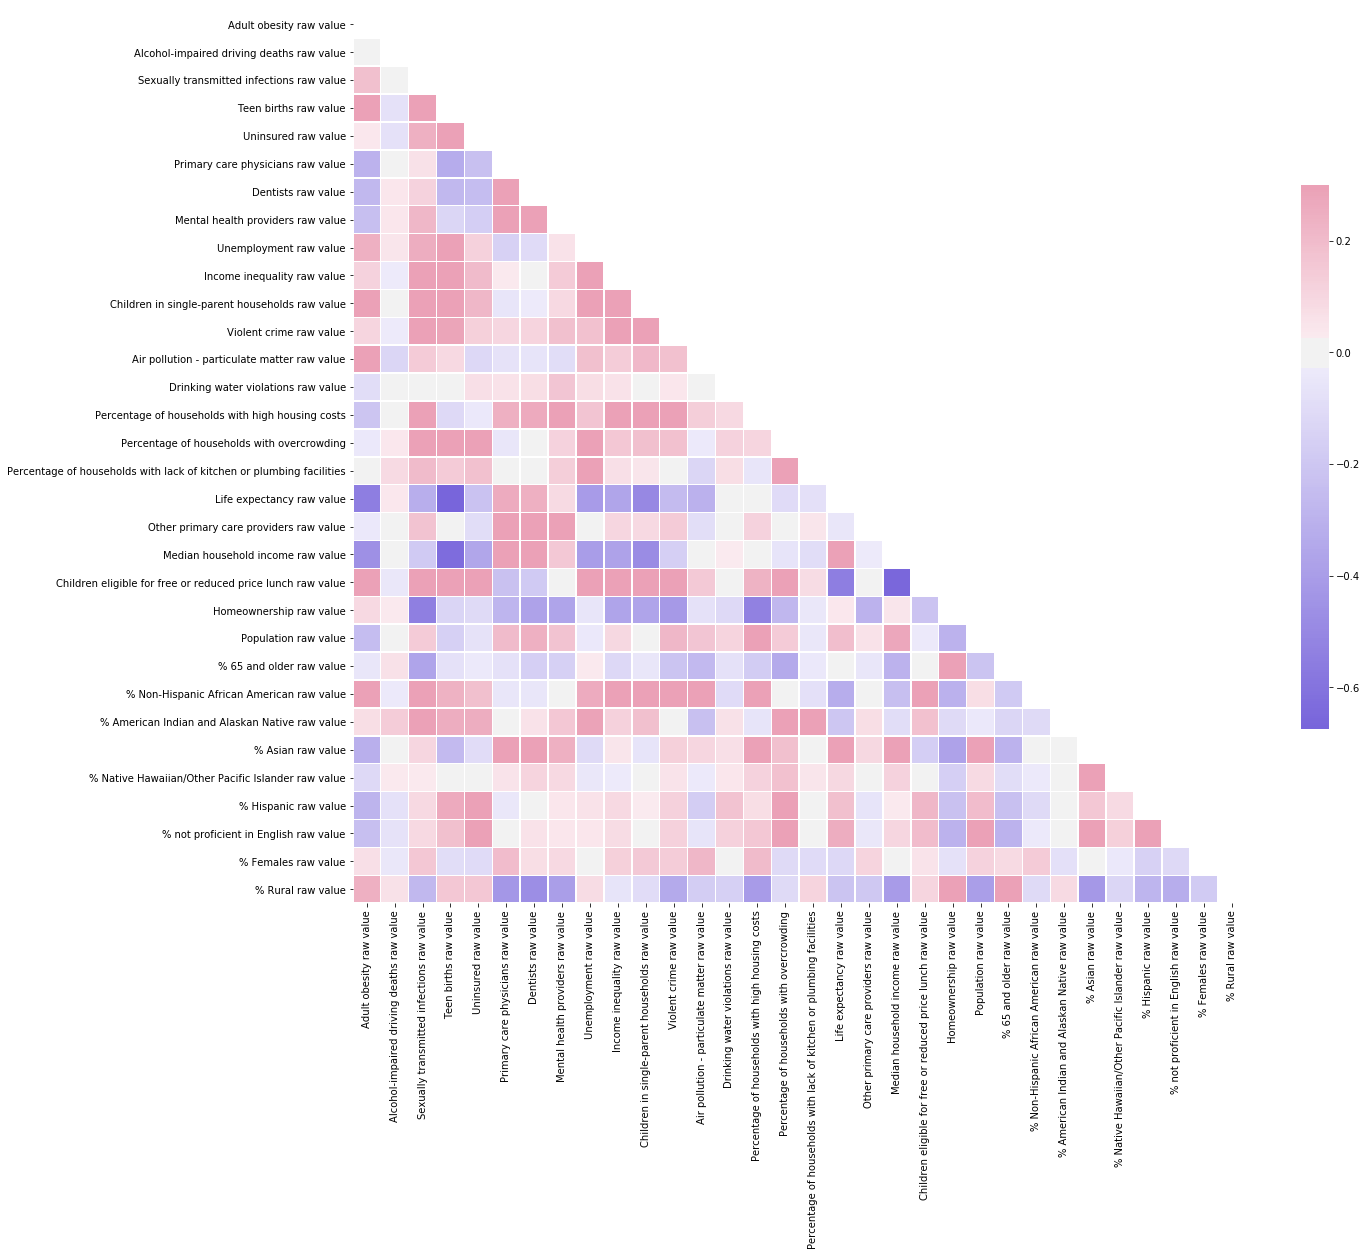

In [49]:
## Generate correlation matrix
corr_matrix = features.corr()

# Plot correlation matrix
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(270, 0, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Check missing data again

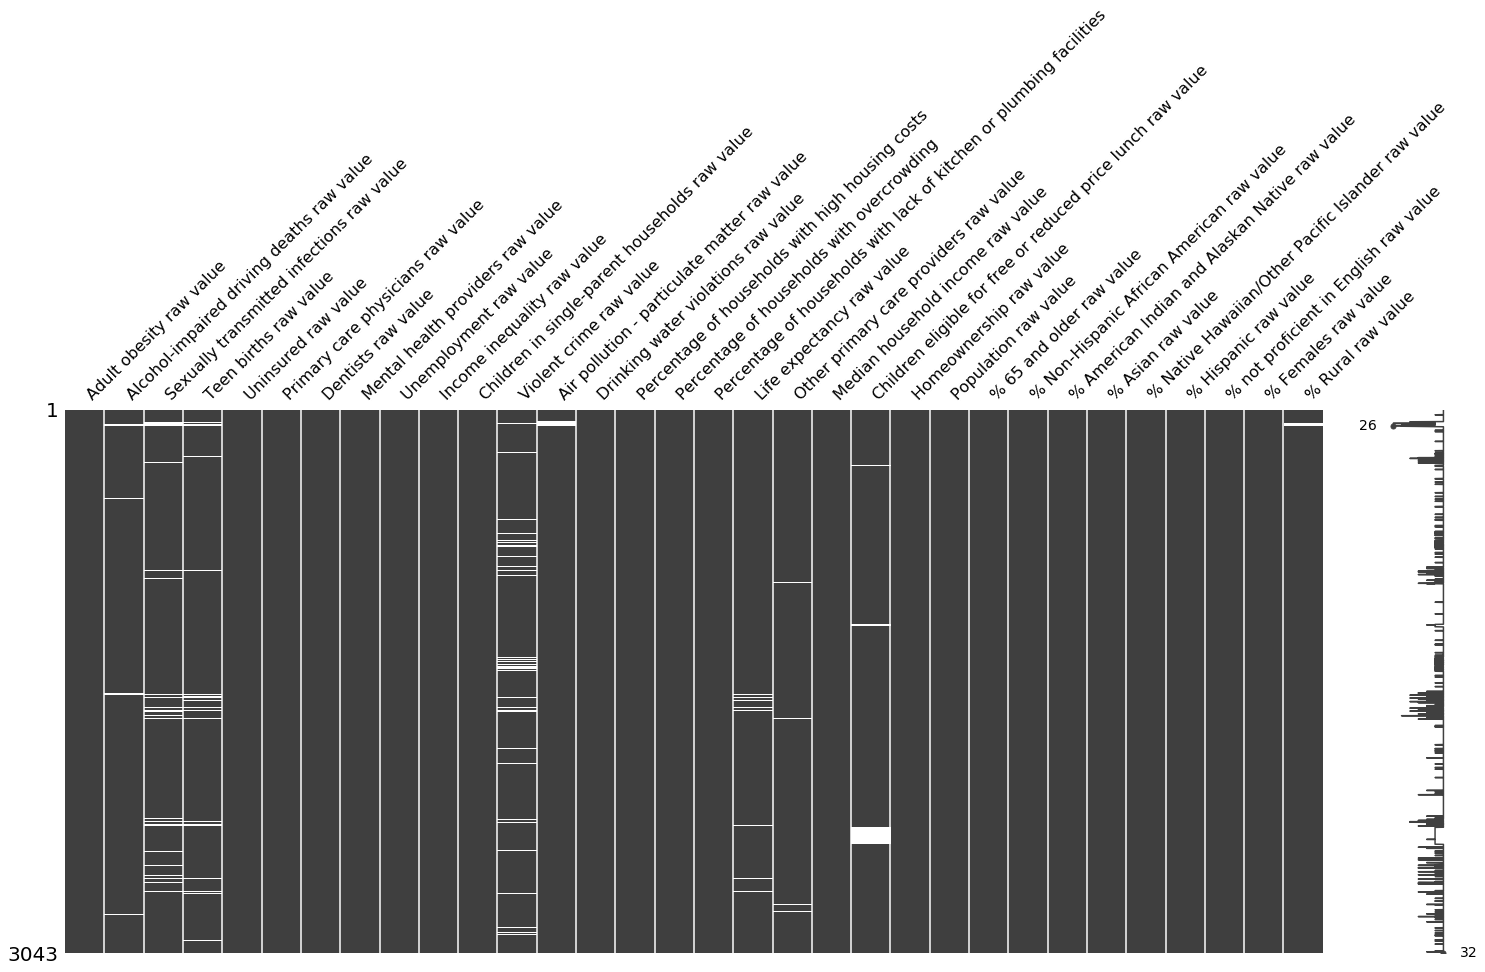

In [50]:
msno.matrix(features)

In [51]:
features.isna().mean().sort_values()

Adult obesity raw value                                                 0.000000
% not proficient in English raw value                                   0.000000
% Hispanic raw value                                                    0.000000
% Native Hawaiian/Other Pacific Islander raw value                      0.000000
% Asian raw value                                                       0.000000
% American Indian and Alaskan Native raw value                          0.000000
% Non-Hispanic African American raw value                               0.000000
% 65 and older raw value                                                0.000000
Population raw value                                                    0.000000
Homeownership raw value                                                 0.000000
Median household income raw value                                       0.000000
Percentage of households with lack of kitchen or plumbing facilities    0.000000
% Females raw value         

### Fill missing with average value for column

In [52]:
for col in features.columns:
    a = features[col].mean()
    features[col].fillna(a, inplace=True)

C:\Users\prayt\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


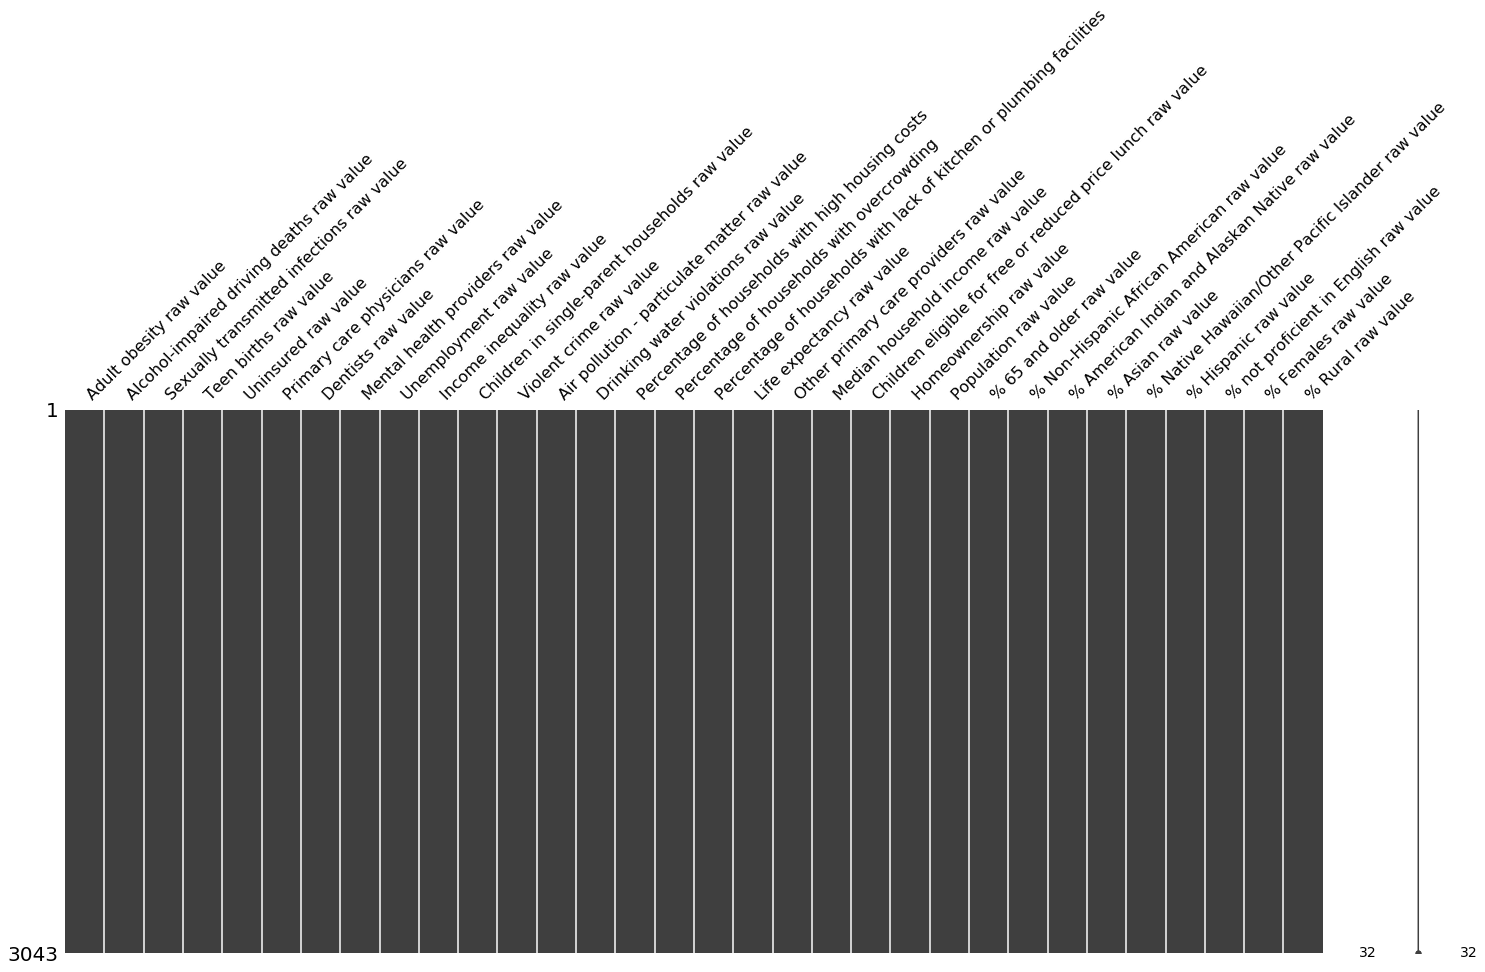

In [53]:
msno.matrix(features)

### Check feature variance

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000135388E8828>,
      dtype=object)

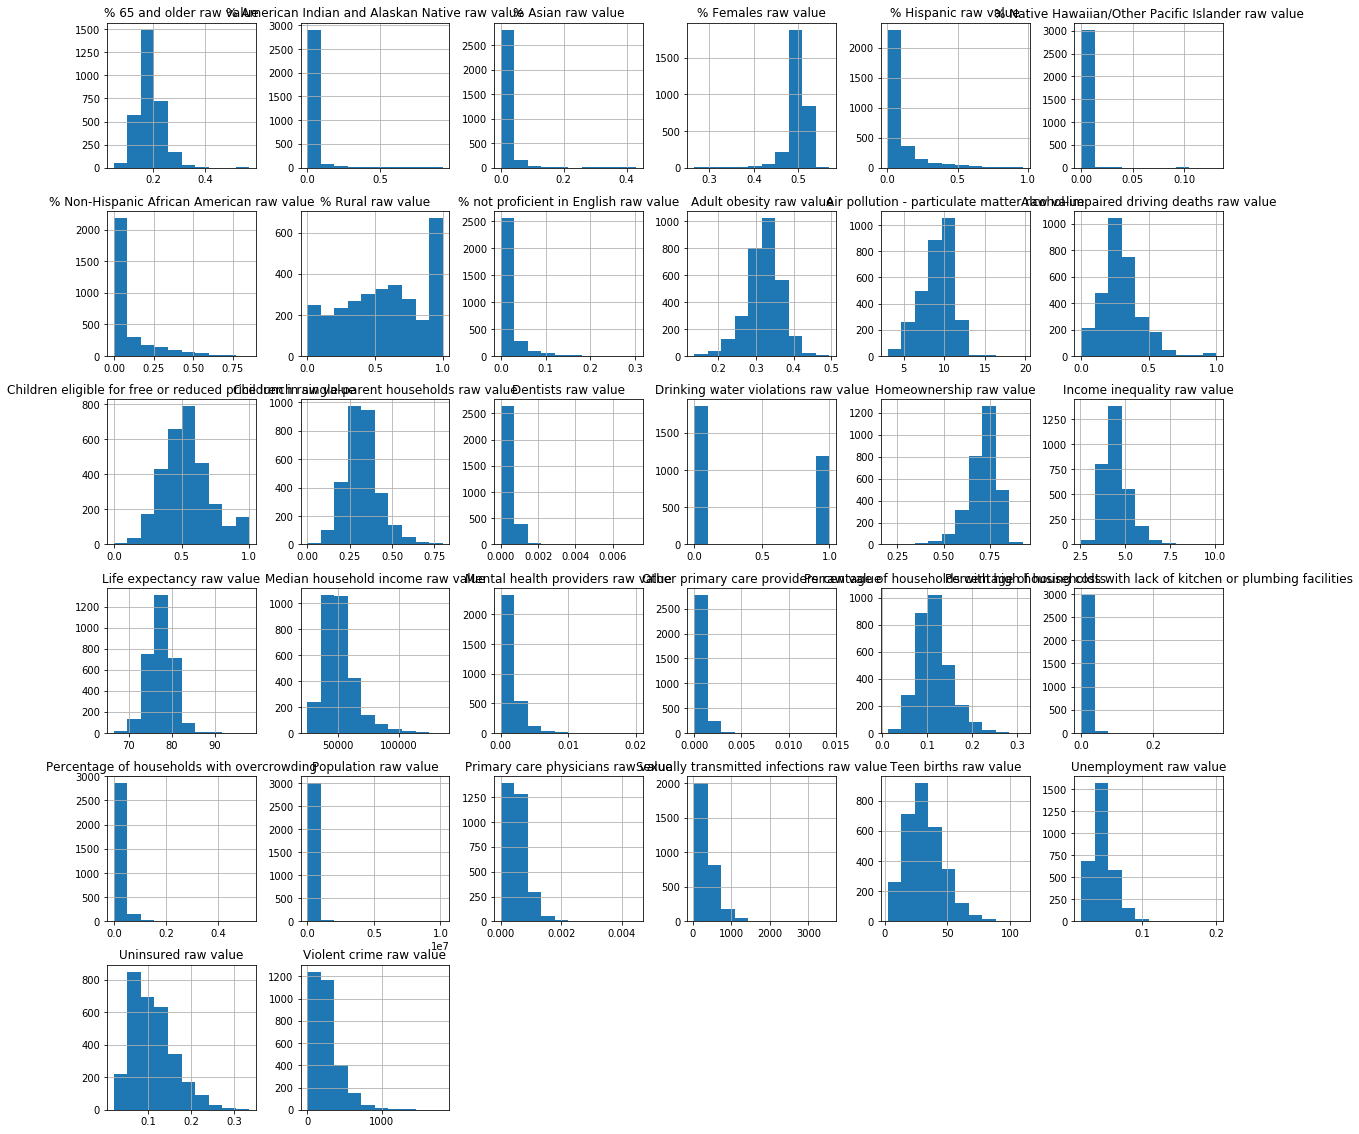

In [54]:
features.hist(figsize=(20,20))

### Create pickle object for future use

In [ ]:
import pickle
clean_data = {
    'features': features,
    'target': target,
    'features_and_orig_hs_rates':target_and_features_df
    }
with open('clean_data.pickle', 'wb') as f:
    pickle.dump(clean_data, f, pickle.HIGHEST_PROTOCOL)

# Lets start modeling!

In [10]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
with open('clean_data.pickle', 'rb') as f:
    a_pickle = pickle.load(f)
features = a_pickle['features']
target = a_pickle['target']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=9373)

In [4]:
X_train.isna().any()

Adult obesity raw value                                                 False
Alcohol-impaired driving deaths raw value                               False
Sexually transmitted infections raw value                               False
Teen births raw value                                                   False
Uninsured raw value                                                     False
Primary care physicians raw value                                       False
Dentists raw value                                                      False
Mental health providers raw value                                       False
Unemployment raw value                                                  False
Income inequality raw value                                             False
Children in single-parent households raw value                          False
Violent crime raw value                                                 False
Air pollution - particulate matter raw value                    

In [5]:
scaler = RobustScaler()
pca = PCA()

logr = LogisticRegression() 
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
Xboost = xgb.XGBClassifier()
svc = SVC()

model_list = [knn, rfc, Xboost, svc]


### Ballpark # of PC's to keep
7 accounts for 95% of variation, we can experiment with #pcs around this.  

In [ ]:
pca_pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca)])
pca_pipe.set_params(pca__n_components=.95, pca__random_state=9373).fit_transform(X_train)
pca_pipe['pca'].explained_variance_ratio_

sns.scatterplot(range(pca_pipe['pca'].explained_variance_ratio_.shape[0]), np.cumsum(pca_pipe['pca'].explained_variance_ratio_))
plt.hlines(.95, 0, 31, color='red')


### KNN Model - very overfit - but still outperforms all the other models by a narrow margin on test.  

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler), 
                       #('pca', pca), 
                       ('knn', knn)])

param_grid = {'knn__n_neighbors':list(range(22,30)),
             'knn__weights':['distance'],
             'knn__algorithm':['auto'],
             'knn__p':[1],
             }

knn_gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
knn_gs.fit(X_train, y_train)
print(knn_gs.score(X_train, y_train))
print(knn_gs.score(X_test, y_test))
knn_gs.best_params_
confusion_matrix(y_test, knn_gs.predict(X_test))

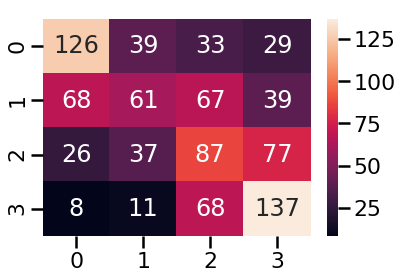

In [81]:
knn_conf = confusion_matrix(y_test, knn_gs.predict(X_test))
ax = sns.heatmap(knn_conf, annot=True, fmt="d")
plt.savefig('images/knn_conf_matrix.jpg')

### RandomForest Model  -  very overfit - overfitting seems to be an issue here....

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('rfc', rfc)])

param_grid = {#'pca__n_components':[10,11,12],
             'rfc__n_estimators':[10,100,500],
             'rfc__max_depth':[5,10,20],
             'rfc__random_state':[9373]}

rfc_gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
rfc_gs.fit(X_train, y_train)
print(rfc_gs.score(X_train, y_train))
print(rfc_gs.score(X_test, y_test))
rfc_gs.best_params_
confusion_matrix(y_test, rfc_gs.predict(X_test))

### XGBoost model  

In [ ]:
# df.drop('State FIPS Code', 'County FIPS Code', '5-digit FIPS Code',
#        'State Abbreviation', 'Name', 'Release Year',
#        'County Ranked (Yes=1/No=0)')

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler), 
                       #('pca', pca), 
                       ('xgb', Xboost)])
param_grid = {'xgb__eta':[.001],
             'xgb__gamma':[1,10],
             'xgb__max_depth':[5],
             'xgb__random_state':[9373]}

xgb_gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
xgb_gs.fit(X_train, y_train)
print(xgb_gs.score(X_test, y_test))
print(xgb_gs.best_params_)
confusion_matrix(y_test, xgb_gs.predict(X_test))


In [14]:
rscaled = RobustScaler()
X_train_scaled = rscaled.fit_transform(X_train)
X_test_scaled = rscaled.transform(X_test)

xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train_scaled, y_train)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                     index=X_train.columns, 
                     columns=["importance"]
                    ).sort_values(by="importance", ascending=False)
                                
        xgc_scores[k] = [i,
                         j,
                         xgc.score(X_train_scaled, y_train),
                         xgc.score(X_test_scaled, y_test),
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1

In [15]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train",
                                    "test",
                                    "n_features"
                                   ]).T

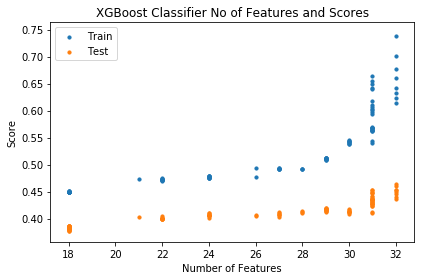

In [18]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Score")
plt.xlabel("Number of Features")

plt.legend(["Train","Test"])
plt.tight_layout()
#plt.savefig("../images/xgc_reg_score")

In [35]:
with open('reg_test_pickle.pickle', 'rb') as f:
    d_pickle = pickle.load(f)
reg_test_df = d_pickle['df']

In [36]:
reg_target = reg_test_df['hs_grad_bins']
reg_test_df.drop(['State FIPS Code', 'County FIPS Code', '5-digit FIPS Code',
       'State Abbreviation', 'Name', 'Release Year',
       'County Ranked (Yes=1/No=0)', 'hs_grad_bins', 'High school graduation raw value'], axis=1, inplace=True)
for col in reg_test_df.columns:
    a = reg_test_df[col].mean()
    reg_test_df[col].fillna(a, inplace=True)

In [38]:
reg_test_df.head()

,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Low birthweight raw value,Adult smoking raw value,Adult obesity raw value,Food environment index raw value,Physical inactivity raw value,Access to exercise opportunities raw value,Excessive drinking raw value,Alcohol-impaired driving deaths raw value,Sexually transmitted infections raw value,Teen births raw value,Uninsured raw value,Primary care physicians raw value,Dentists raw value,Mental health providers raw value,Preventable hospital stays raw value,Mammography screening raw value,Flu vaccinations raw value,Some college raw value,Unemployment raw value,Children in poverty raw value,Income inequality raw value,Children in single-parent households raw value,Social associations raw value,Violent crime raw value,Injury deaths raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,Severe housing problems raw value,Percentage of households with high housing costs,Percentage of households with overcrowding,Percentage of households with lack of kitchen or plumbing facilities,Driving alone to work raw value,Long commute - driving alone raw value,Life expectancy raw value,Premature age-adjusted mortality raw value,Frequent physical distress raw value,Frequent mental distress raw value,Diabetes prevalence raw value,Food insecurity raw value,Limited access to healthy foods raw value,Insufficient sleep raw value,Uninsured adults raw value,Uninsured children raw value,Other primary care providers raw value,Median household income raw value,Children eligible for free or reduced price lunch raw value,Homeownership raw value,Severe housing cost burden raw value,Population raw value,% below 18 years of age raw value,% 65 and older raw value,% Non-Hispanic African American raw value,% American Indian and Alaskan Native raw value,% Asian raw value,% Native Hawaiian/Other Pacific Islander raw value,% Hispanic raw value,% Non-Hispanic white raw value,% not proficient in English raw value,% Females raw value,% Rural raw value
3,8824.057123,0.184111,4.200578,4.306739,0.084757,0.191247,0.375,7.2,0.311,0.686775,0.168780,0.288136,341.2,26.524208,0.085010,0.000415,0.000324,0.000162,6599.0,0.44,0.41,0.608547,0.038635,0.193,4.636664,0.247001,12.631731,272.282220,74.031808,11.7,0.0,0.149546,0.132052,0.024516,0.006374,0.859651,0.383,76.330589,438.7,0.128244,0.126384,0.142,0.134,0.119911,0.359054,0.109611,0.024762,0.000306,58343,0.479317,0.732877,0.126452,55504,0.239370,0.151196,0.192545,0.004756,0.012792,0.001045,0.028575,0.744739,0.008285,0.513422,0.420022
4,7224.632160,0.180605,4.098748,4.249649,0.083387,0.167955,0.310,8.0,0.238,0.719710,0.167150,0.318750,338.8,29.594009,0.106993,0.000729,0.000499,0.000912,3833.0,0.45,0.45,0.661339,0.039883,0.147,4.518560,0.251841,10.692213,203.660396,69.374289,10.3,1.0,0.138317,0.125693,0.010728,0.006072,0.847194,0.405,78.599498,348.4,0.126220,0.128226,0.113,0.123,0.054244,0.333059,0.135703,0.032380,0.000522,56607,0.450791,0.728593,0.127959,212628,0.218485,0.199470,0.089532,0.007760,0.011565,0.000687,0.045502,0.830474,0.004545,0.514528,0.422791
5,9586.165037,0.257734,5.067438,4.634994,0.109526,0.215409,0.443,5.6,0.282,0.536257,0.126987,0.296296,557.9,45.092838,0.125132,0.000385,0.000356,0.000079,4736.0,0.46,0.37,0.367740,0.059009,0.503,5.755063,0.572157,8.472944,414.277861,72.900134,11.5,0.0,0.154555,0.136743,0.020065,0.008134,0.834044,0.338,75.779457,469.8,0.162162,0.146323,0.180,0.232,0.107397,0.385632,0.165422,0.029014,0.000237,32490,0.737698,0.625068,0.135868,25270,0.207638,0.188247,0.479422,0.006529,0.004630,0.001860,0.042066,0.459557,0.011993,0.472299,0.677896
6,11783.543675,0.199969,4.363377,4.315710,0.111050,0.199164,0.378,7.6,0.349,0.162514,0.159252,0.272727,302.1,45.454545,0.096801,0.000574,0.000265,0.000088,5998.0,0.44,0.39,0.484063,0.043851,0.273,4.254594,0.295654,10.157665,89.349126,100.077937,11.2,0.0,0.109609,0.108081,0.001993,0.002847,0.8636

In [39]:
rX_train, rX_test, ry_train, ry_test = train_test_split(reg_test_df, reg_target, test_size=.3, random_state=9373)

In [41]:
rscaled = RobustScaler()
X_train_scaled = rscaled.fit_transform(rX_train)
X_test_scaled = rscaled.transform(rX_test)

xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train_scaled, ry_train)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                     index=rX_train.columns, 
                     columns=["importance"]
                    ).sort_values(by="importance", ascending=False)
                                
        xgc_scores[k] = [i,
                         j,
                         xgc.score(X_train_scaled, ry_train),
                         xgc.score(X_test_scaled, ry_test),
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1

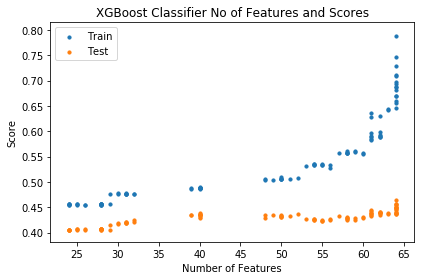

In [42]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train",
                                    "test",
                                    "n_features"
                                   ]).T

plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Score")
plt.xlabel("Number of Features")

plt.legend(["Train","Test"])
plt.tight_layout()

### SVC Model

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler), 
                       #('pca', pca), 
                       ('svc', svc)])

param_grid = {#'pca__n_components':[18,19],
             'svc__gamma':['auto'],
             'svc__kernel':['rbf'],
             'svc__C':[.01,.1],
             'svc__random_state':[9373]}

svc_gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
svc_gs.fit(X_train, y_train)
print(svc_gs.score(X_train, y_train))
print(svc_gs.score(X_test, y_test))
print(svc_gs.best_params_)
confusion_matrix(y_test, svc_gs.predict(X_test))

### Logistic Regression

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logr', logr)])

param_grid = {'pca__n_components':[25,31,35],
             'logr__penalty':['l2'],
             'logr__solver':['saga'],
             'logr__C':[.05,.1],
             'logr__random_state':[9373],
             'logr__max_iter':[1000]}

logr_gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', error_score=0.0)
logr_gs.fit(X_train, y_train)
print(logr_gs.score(X_train, y_train))
print(logr_gs.score(X_test, y_test))
print(logr_gs.best_params_)
confusion_matrix(y_test, logr_gs.predict(X_test))

### Create pickle for models

In [ ]:
models_pickle = {
    'knn': knn_gs,
    'rfc': rfc_gs,
    'svc': svc_gs,
    'xgb': xgb_gs,
    'logr': logr_gs,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
    }
with open('models.pickle', 'wb') as f:
    pickle.dump(models_pickle, f, pickle.HIGHEST_PROTOCOL)

## Clustering

In [1]:
from sklearn.metrics.cluster import calinski_harabasz_score, adjusted_rand_score
from sklearn.cluster import KMeans

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Import Pickle

In [78]:
with open('models.pickle', 'rb') as f:
    b_pickle = pickle.load(f)
knn_gs = b_pickle['knn']
rfc_gs = b_pickle['rfc']
svc_gs = b_pickle['svc']
xgb_gs = b_pickle['xgb']
logr_gs = b_pickle['logr']
X_train = b_pickle['X_train']
X_test = b_pickle['X_test']
y_train = b_pickle['y_train']
y_test = b_pickle['y_test']
#target_and_features_df = b_pickle['target_and_features_df']

### Create Cluster df

In [2]:
with open('clean_data.pickle', 'rb') as f:
    d_pickle = pickle.load(f)
cluster_df = d_pickle['features_and_orig_hs_rates']

cluster_labels_df = cluster_df[['State FIPS Code', 'County FIPS Code', '5-digit FIPS Code', 'hs_grad_bins', 'State Abbreviation']]
cluster_features_df = cluster_df.drop(['State FIPS Code', 'County FIPS Code', '5-digit FIPS Code', 'Name','Release Year', 'County Ranked (Yes=1/No=0)','hs_grad_bins','State Abbreviation'], axis=1)

In [17]:
cluster_features_df['Median household income raw value'].quantile(np.linspace(.25,.75,3));

In [15]:
income_bins = pd.qcut(cluster_features_df['Median household income raw value'], 4, labels=['med family income<$42000      ', 
                                                        'med family income $42000-49000',
                                                        'med family income $49000-56700',
                                                        'med family income>$56700      '])


In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cluster_features_df)
pca_df = PCA(.95).fit_transform(scaled_df)
ks =[]
labeled=[]
for cluster in list(range(2,10)):
    k_means = KMeans(n_clusters=cluster, 
                     init='k-means++', 
                     random_state=5341, max_iter=500)
    k_means.fit(pca_df)
    preds = k_means.labels_
    labeled.append(k_means.labels_)
    ks.append(calinski_harabasz_score(scaled_df, preds))


In [70]:
np.unique(labeled[2])

array([0, 1, 2, 3])

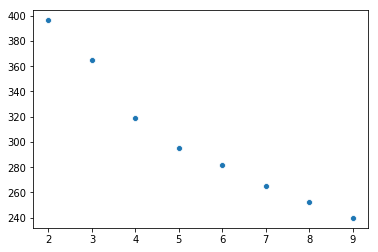

In [25]:
sns.scatterplot(list(range(2,10)), ks)

In [47]:
labeled[4]

array([4, 0, 1, ..., 0, 0, 0])

In [41]:
cluster_features_df.columns

Index(['Adult obesity raw value', 'Alcohol-impaired driving deaths raw value',
       'Sexually transmitted infections raw value', 'Teen births raw value',
       'Uninsured raw value', 'Primary care physicians raw value',
       'Dentists raw value', 'Mental health providers raw value',
       'High school graduation raw value', 'Unemployment raw value',
       'Income inequality raw value',
       'Children in single-parent households raw value',
       'Violent crime raw value',
       'Air pollution - particulate matter raw value',
       'Drinking water violations raw value',
       'Percentage of households with high housing costs',
       'Percentage of households with overcrowding',
       'Percentage of households with lack of kitchen or plumbing facilities',
       'Life expectancy raw value', 'Other primary care providers raw value',
       'Median household income raw value',
       'Children eligible for free or reduced price lunch raw value',
       'Homeownership raw val

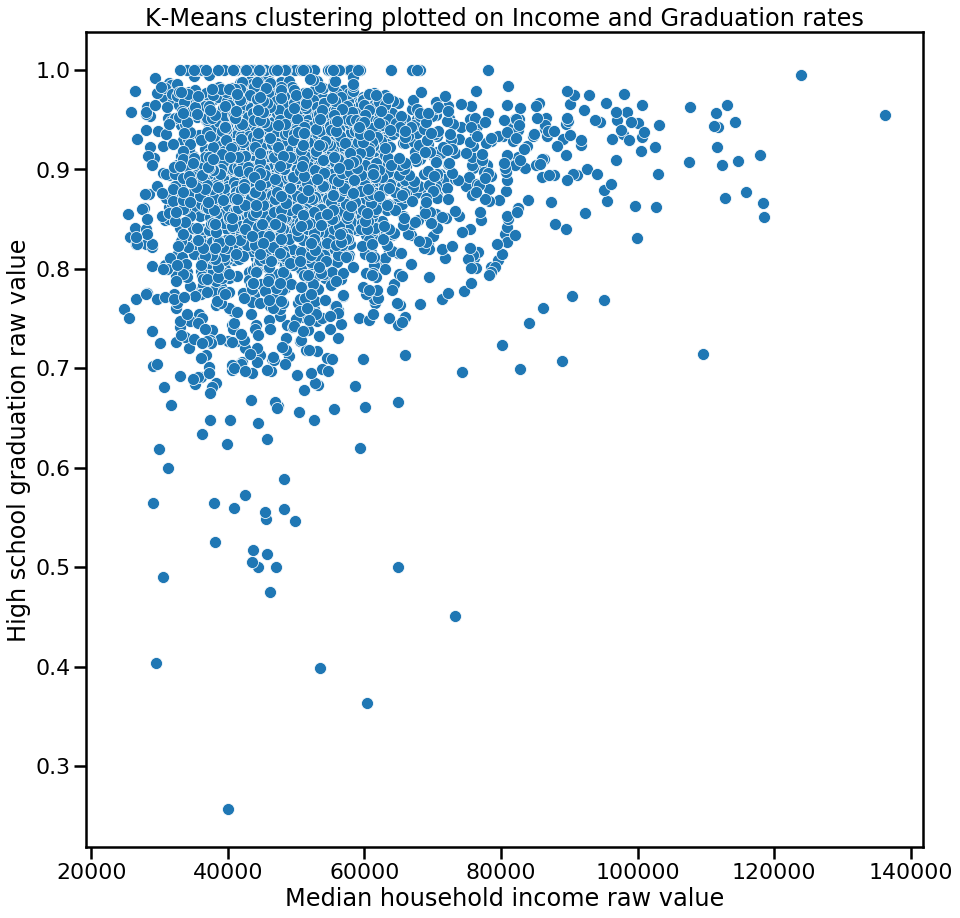

In [82]:
plt.figure(figsize=(15,15))
sns.scatterplot(cluster_features_df['Median household income raw value'], 
                cluster_features_df['High school graduation raw value'], 
               )
plt.title('K-Means clustering plotted on Income and Graduation rates')
sns.set_context('poster')
plt.savefig('images/income_grad_rates.jpg')

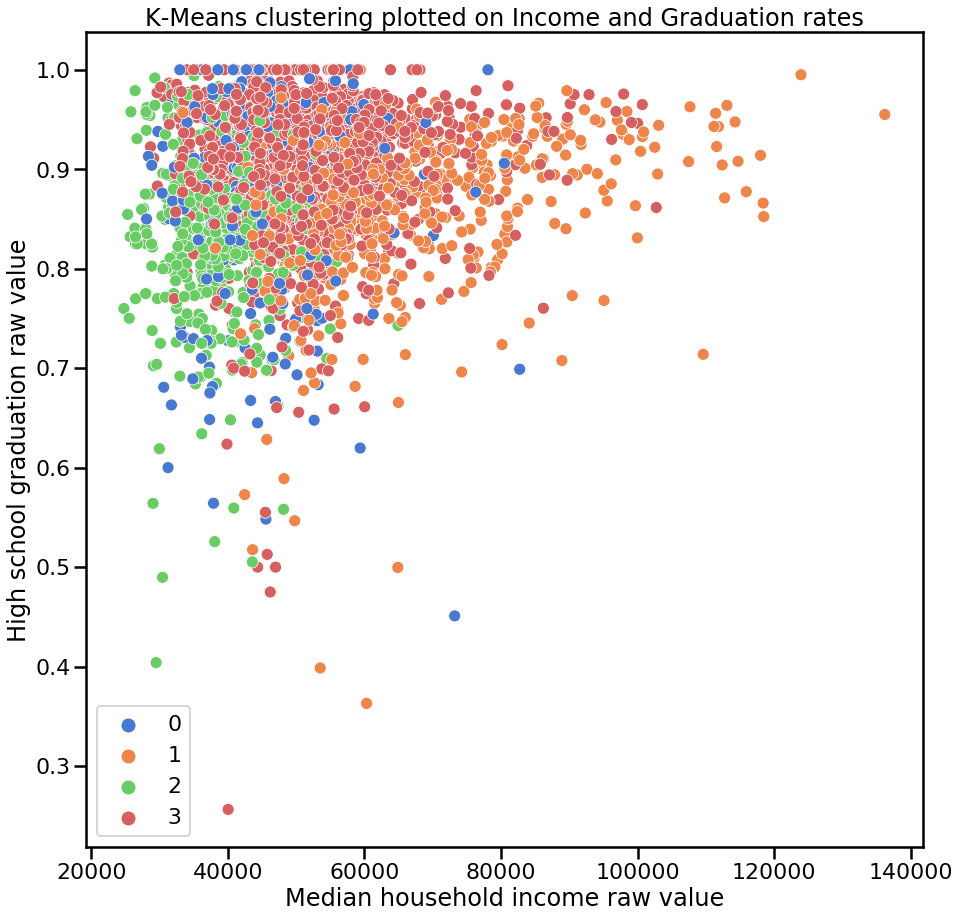

In [73]:
plt.figure(figsize=(15,15))
sns.scatterplot(cluster_features_df['Median household income raw value'], 
                cluster_features_df['High school graduation raw value'], 
                hue=labeled[2], 
                palette=sns.color_palette("muted", n_colors=4)
               )
plt.title('K-Means clustering plotted on Income and Graduation rates')
sns.set_context('poster')
plt.savefig('images/kcluster_income_grad_rates.jpg')

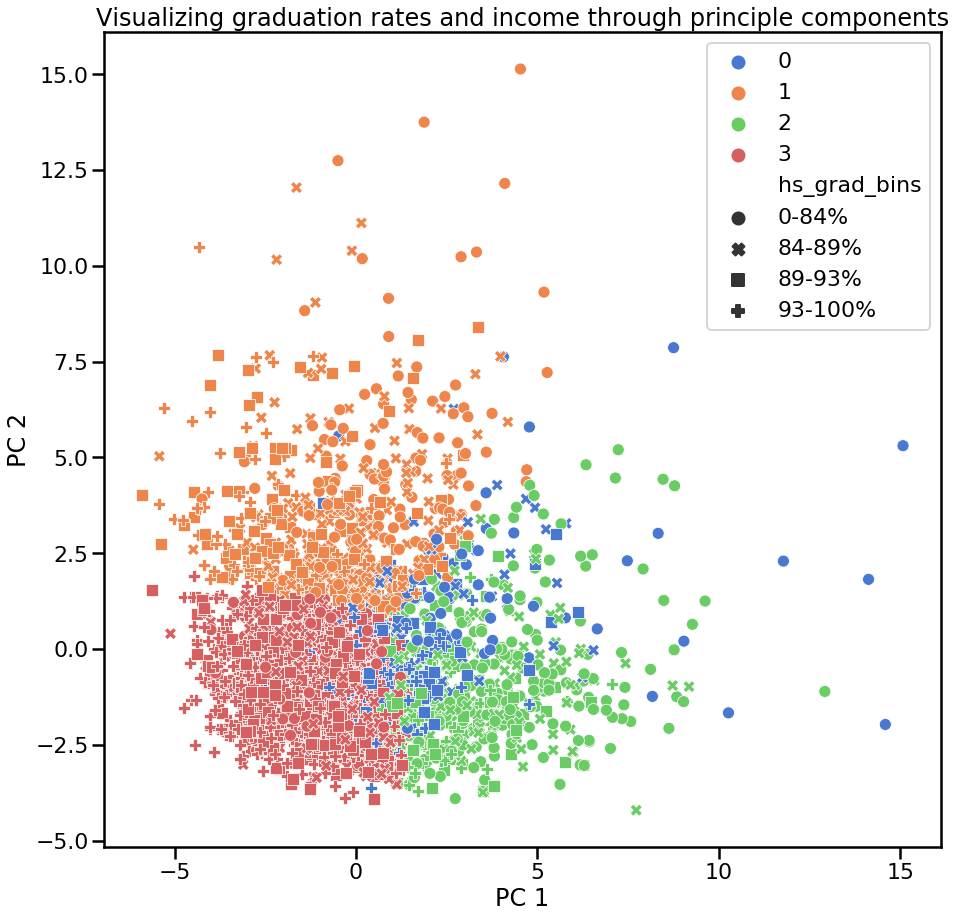

In [86]:
plt.figure(figsize=(15,15))
sns.scatterplot(pca_df[:,0], pca_df[:,1], hue=labeled[2], style=cluster_labels_df['hs_grad_bins'], 
                palette=sns.color_palette("muted", n_colors=4))
sns.set_context('poster')
plt.title('Visualizing graduation rates and income through principle components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.savefig('images/pc_grad_rate.jpg')

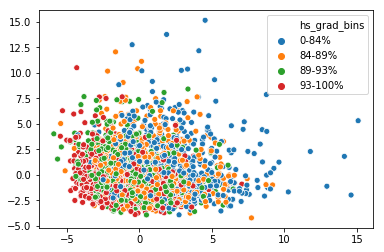

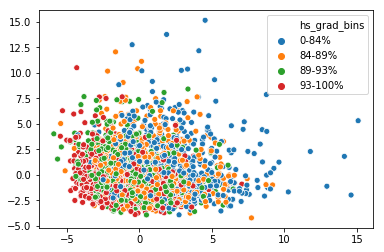

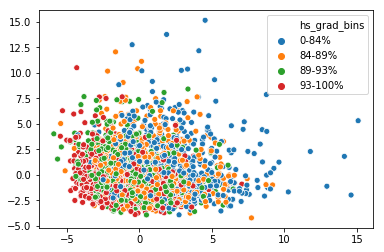

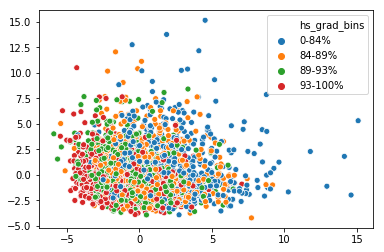

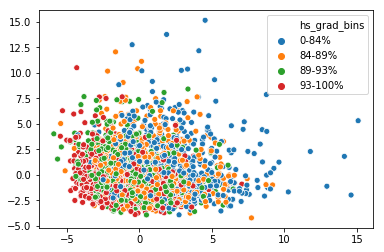

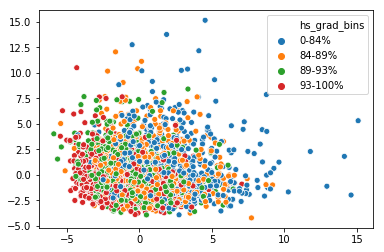

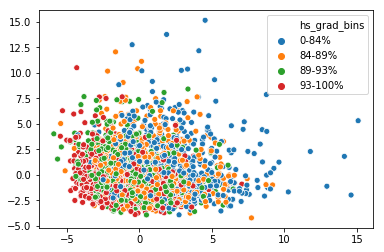

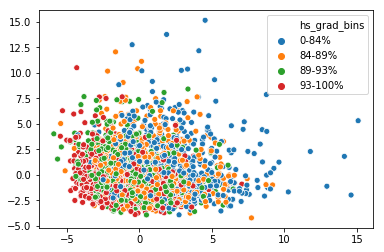

In [22]:
for label in labeled:
    ax = plt.figure()
    sns.scatterplot(pca_df[:,0], pca_df[:,1], hue=cluster_labels_df['hs_grad_bins']), style=label)

In [ ]:
len(list(range(0,18)))